In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import Fluka_dump_tools as fdt


In [2]:
# User inputs

# Path to the Feather file
feather_file = "~/Desktop/phiKK_4550_MeV_9663_files.ftr"

# outpute LHE file name
output_name = "phiKK_4550_MeV_9663.lhe"

# output directory
output_dir = "/Users/mghrear/Desktop"

In [3]:
# Create a DataFrame from the Feather file
df = pd.read_feather(feather_file)

# Keep only 2nd gen events, starting with a photon, with one K+ and one K- secondaries
df['Kflag'] = df.IDs.apply(lambda x: np.count_nonzero(x == 16) == 1)
df['Kflag2'] = df.IDs.apply(lambda x: np.count_nonzero(x == 15) == 1)
df_phiKK = df.loc[(df.Kflag == True)&(df.Kflag2 == True) &(df.Gen_No == 2)&(df.ProjID == 7)  ].reset_index(drop=True)


In [4]:
# Compute the invariant mass of the K+K- pair

# mass of kaon
mK = 0.493677

# Get the momentum and energy of the kaons
df_phiKK['PKm'] = df_phiKK.apply(lambda row: np.array([row.dir_xs[row.IDs == 16].item(),row.dir_ys[row.IDs == 16].item(),row.dir_zs[row.IDs == 16].item()])*row.Ps[row.IDs == 16].item() , axis=1)
df_phiKK['PKp'] = df_phiKK.apply(lambda row: np.array([row.dir_xs[row.IDs == 15].item(),row.dir_ys[row.IDs == 15].item(),row.dir_zs[row.IDs == 15].item()])*row.Ps[row.IDs == 15].item() , axis=1)
df_phiKK['EKm'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 16].item()**2 / ( mK**2 + row.Ps[row.IDs == 16].item()**2 ) )) , axis=1)
df_phiKK['EKp'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 15].item()**2 / ( mK**2 + row.Ps[row.IDs == 15].item()**2 ) )) , axis=1)

# Calculate the invariant mass 
df_phiKK['M']= df_phiKK.apply(lambda row: np.sqrt((row.EKp+row.EKm)**2 - (row.PKm+row.PKp).dot(row.PKm+row.PKp)) , axis=1)

Text(0, 0.5, 'Counts')

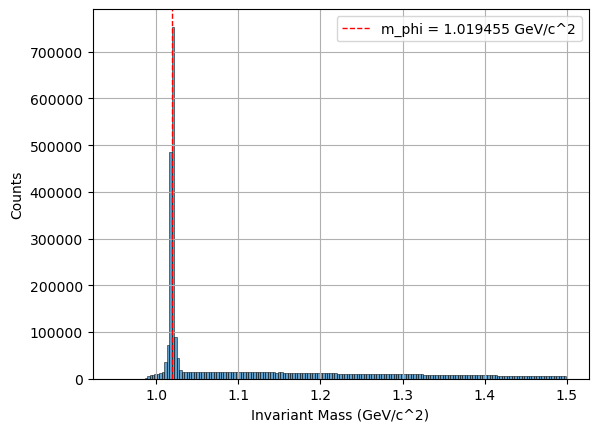

In [5]:
# Plot the invariant mass distribution of the K+K- pair

# mass of the phi meson
m_phi = 1.019455

df_phiKK.M.hist(bins=np.arange(0.95, 1.5, 0.003), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 


Text(0, 0.5, 'Counts')

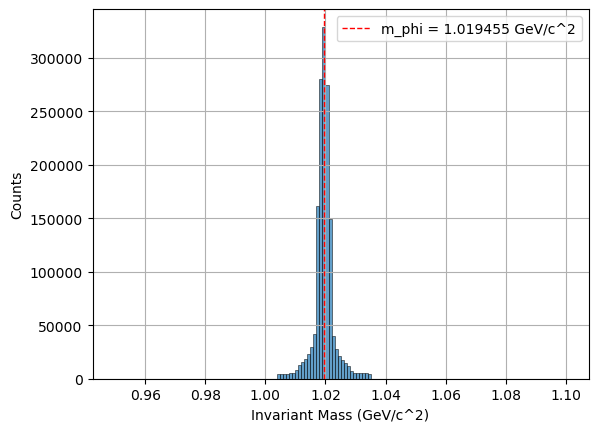

In [6]:
# Make a selection around the phi mass, for now we take these as phi-> K+ K-  events
selec_window = 0.0155

df_phiKK_cut = df_phiKK.loc[(df_phiKK.M > m_phi-selec_window) & (df_phiKK.M < m_phi+selec_window)].reset_index(drop=True)

df_phiKK_cut.M.hist(bins=np.arange(0.95, 1.1, 0.001), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 

In [7]:
# Get all the fluka IDs for the secondary particles
unique_fluka_ids_df = df_phiKK_cut.explode('IDs')['IDs'].unique()
keys_view = fdt.flukaIDdict.keys() 
keys_list = np.array(list(keys_view))

missing_keys = np.setdiff1d(unique_fluka_ids_df, keys_list)

if len(missing_keys) > 0:
    print("Error add the following fluka IDs to flukaIDdict: ", missing_keys)

else:
    # Apply the conversion and create new columns
    df_phiKK_cut[['PDG_IDs', 'Sec_mass', 'Sec_charge']] = df_phiKK_cut['IDs'].apply(fdt.convert_fluka_ids).apply(pd.Series)

In [8]:
fdt.write_lhe(df_phiKK_cut, output_dir, output_name, include_recoil_e = True, include_other_secondaries = False, elastic_only = False)

LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_9663.lhe
